In [1]:
import math
import matplotlib.pyplot as plt
import gprsim
import numpy as np

## A really noisy simulation

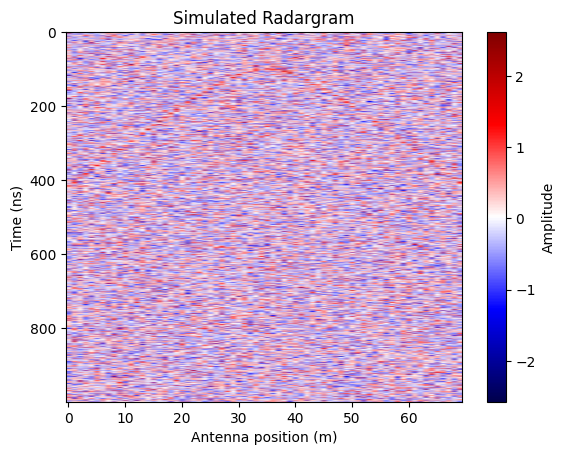

In [470]:
# Parameters
eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
SNR = 0.009
wavetype = 'gaussian'

# Point reflectors at (x,t) where x [m] and t [s]
reflectors = [(35, 50e-9)]

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)

plt.imshow(data, aspect='auto', cmap='seismic')
plt.xlabel("Antenna position (m)")
plt.ylabel("Time (ns)")
plt.title("Simulated Radargram")
plt.colorbar(label="Amplitude")
plt.show()

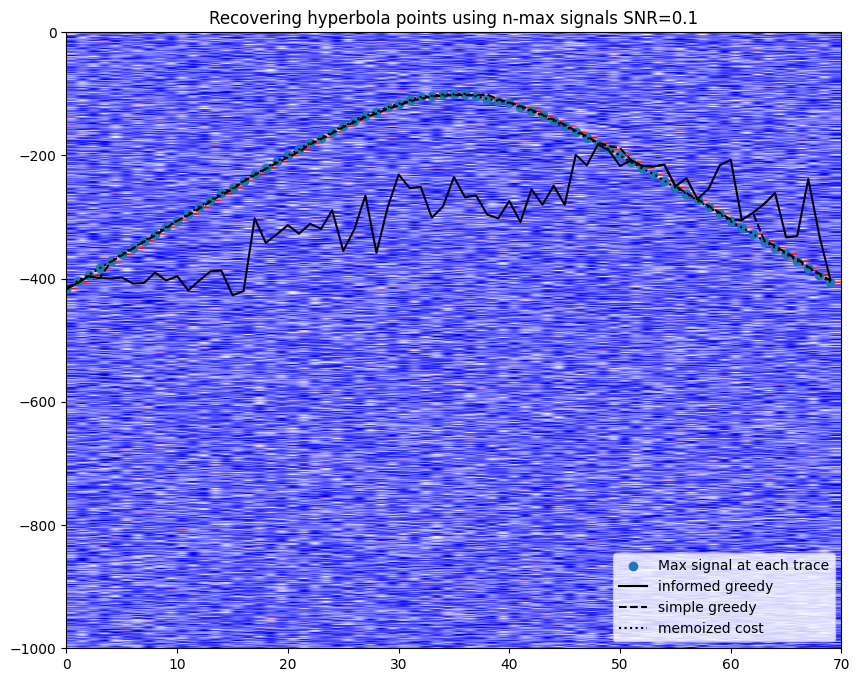

In [245]:
def minimize_tracewise_slope_greedy(data, n_candidates):
    t = data.argsort(axis=0)[::-1,:][0]
    t_og = data.argsort(axis=0)[::-1,:][0]* -1
    x = np.arange(0, data.shape[1]) * dx # 
    t_nmax = data.argsort(axis=0)[::-1,:] * -1

    candidates = np.array([data.argsort(axis=0)[::-1,:][n] for n in range(0,n_candidates)])
    for i in range(0,len(x)): # go through each trace
        candidate_indices = candidates[:, i]
        min_slope = math.inf
        slopes = []
        for cand in candidate_indices:
            slope = np.abs((cand-t[i-1])/(x[i]-x[i-1])) # calcuate the slope for each candidate index
            slopes.append(slope)
            if slope < min_slope: # If the slope suddenly becomes eggerdious
                t[i]=cand
                min_slope = slope
    return x, t

def minimize_tracewise_slope_window(data, n_candidates, dx, window):
    n_traces = data.shape[1]
    x = np.arange(n_traces) * dx
    
    # Precompute top-n candidate indices for each column
    candidates = data.argsort(axis=0)[::-1, :][:n_candidates, :]
    
    # Initialize with the top max of the first column
    t = np.zeros(n_traces, dtype=int)
    t[0] = candidates[0, 0]
    
    for i in range(1, n_traces):
        # Look back over a small window (min ensures bounds)
        start = max(0, i - window)
        prev_t = np.mean(t[start:i])  # local average trend
        
        candidate_indices = candidates[:, i]
        # Compute slope relative to local mean
        slopes = np.abs((candidate_indices - prev_t) / dx)
        # Choose the one that gives the smallest slope
        t[i] = candidate_indices[np.argmin(slopes)]
    
    return x, t

def smooth_path_dp(data, lam):
    nt, nx = data.shape
    C = np.zeros_like(data)
    backtrack = np.zeros_like(data, dtype=int)

    # Initialize first column
    C[:, 0] = data[:, 0]

    # DP forward pass, populate the memoized cost (C) and store the best path so far. This can be improved from n^2 but I thnk it's alright for now
    for x in range(1, nx):
        for t in range(nt):
            # Compute smoothness penalty relative to previous column, slope cost may not be needed
            penalties = C[:, x-1] - lam * (np.arange(nt) - t)**2
            best_prev = np.argmax(penalties)
            C[t, x] = data[t, x] + penalties[best_prev]
            backtrack[t, x] = best_prev

    # Backtrack the best path
    path = np.zeros(nx, dtype=int)
    path[-1] = np.argmax(C[:, -1])
    for x in range(nx-2, -1, -1):
        path[x] = backtrack[path[x+1], x+1]

    return np.arange(0, nx), -path


t, x = data.argsort(axis=0)[::-1,:][0], np.arange(0, data.shape[1]) * dx 
x_window, t_window = minimize_tracewise_slope_window(data, 20, 1, 5)
x_greedy, t_greedy = minimize_tracewise_slope_greedy(data, 15)
x_dynamic, t_dynamic = smooth_path_dp(data, lam=0.001)

fig = plt.figure(figsize=(10,8))
plt.title(f"Recovering hyperbola points using n-max signals SNR={SNR}")
plt.imshow(data, aspect='auto', extent=[0,70,-1000,0], cmap='seismic')
plt.scatter(x, -t, label="Max signal at each trace")
plt.plot(x_window, -t_window, label="informed greedy", c='black', linestyle='-')
plt.plot(x_greedy, -t_greedy, label="simple greedy", c='black', linestyle='--')
plt.plot(x_dynamic, t_dynamic, label="memoized cost", c='black', linestyle=':')
plt.legend(loc="lower right")

Text(0.5, 235.72222222222223, 'x distance (m)')

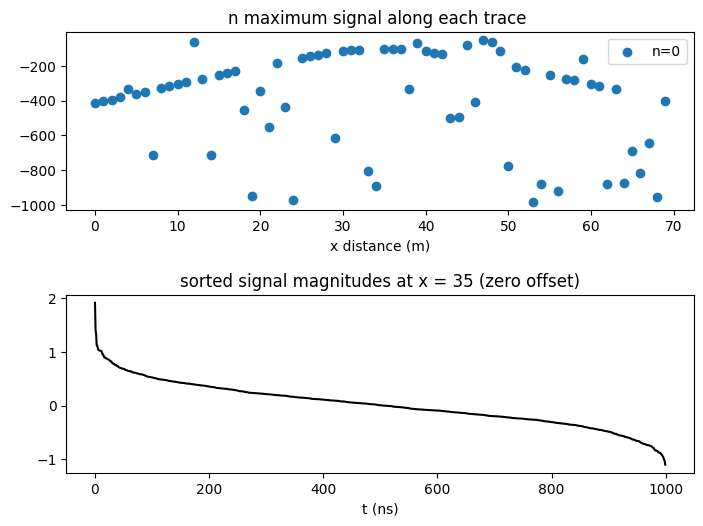

In [401]:
fig, ax = plt.subplots(2, figsize = (7,5))
fig.tight_layout(h_pad=4)

for n in range(0,1):
    t = data.argsort(axis=0)[::-1,:][n]* -1 # Ttake the indices of the max 5 signals
    x = np.arange(0, data.shape[1]) * dx # 
    ax[0].scatter(x, t, label=f"n={n}")

sample_signal = data[:,35]
ax[1].plot(np.sort(sample_signal)[::-1], c='black')
ax[1].set_title("sorted signal magnitudes at x = 35 (zero offset)")
ax[1].set_xlabel("t (ns)")
ax[0].legend()
ax[0].set_title("n maximum signal along each trace ")
ax[0].set_xlabel("x distance (m)")

# The idea is that if we take n maximums, even with super noisy data we will have sufficient data to get the hyperbola

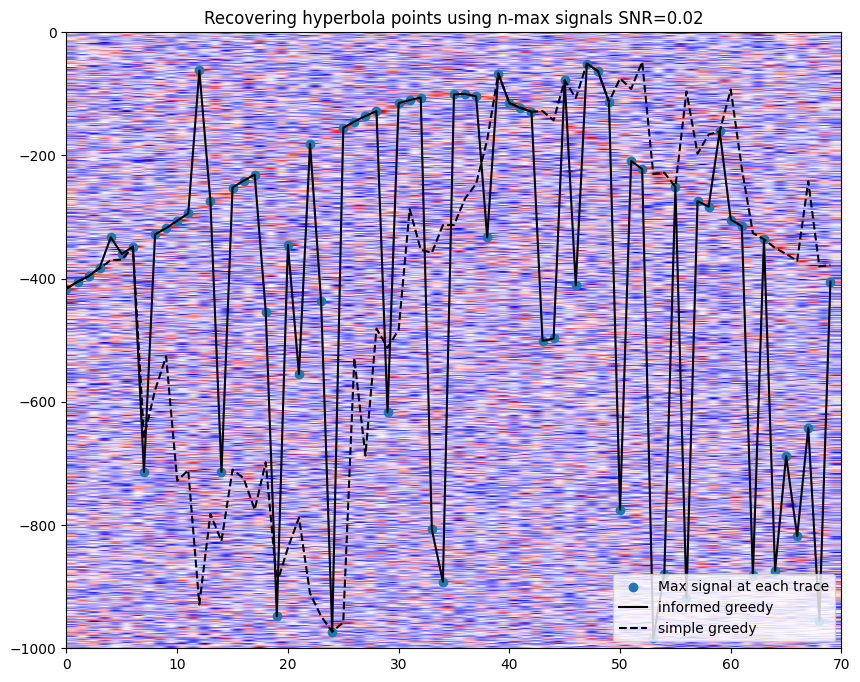

In [424]:
# data preconditioning to qremove isolated slope anomalies
def minimize_tracewise_slope_greedy(data, n_candidates):
    t = data.argsort(axis=0)[::-1,:][0]
    t_og = data.argsort(axis=0)[::-1,:][0]* -1
    x = np.arange(0, data.shape[1]) * dx # 
    t_nmax = data.argsort(axis=0)[::-1,:] * -1

    candidates = np.array([data.argsort(axis=0)[::-1,:][n] for n in range(0,n_candidates)])
    for i in range(1,len(x)): # go through each trace
        candidate_indices = candidates[:, i]
        min_slope = math.inf
        slopes = []
        for cand in candidate_indices:
            slope = np.abs((cand-t[i-1])/(x[i]-x[i-1])) # calcuate the slope for each candidate index
            slopes.append(slope)
            if slope < min_slope: # If the slope suddenly becomes eggerdious
                t[i]=cand
                min_slope = slope
    return x, t

"""
Tracewise slope-constrained path extraction in noisy 2D data.

This function identifies a continuous path (or "ridge") across a noisy 2D array
by selecting, for each column (trace), one of the top `n_candidates` points that
minimizes deviation from a locally consistent slope. The algorithm proceeds
sequentially, using a moving window to estimate the average slope of recent
segments, and choosing the candidate in the next column whose slope best
matches this local trend.

Parameters
----------
data : np.ndarray of shape (n_rows, n_traces)
    2D array representing signal intensity, where each column corresponds to a
    spatial or temporal "trace" and each row corresponds to a sampled value (e.g.,
    depth, time, or vertical position).

n_candidates : int
    Number of top local maxima (by intensity) to consider per column. A higher
    value increases robustness but also computation time.

dx : float
    Horizontal spacing between adjacent traces (used for slope calculation).

window : int
    Number of previous traces to include in the local slope averaging window.
    Controls how strongly the algorithm enforces slope smoothness.

Returns
-------
x : np.ndarray of shape (n_traces,)
    The horizontal coordinate values for each trace.

path : np.ndarray of shape (n_traces,)
    The row indices of the selected path through the data, forming a smooth,
    slope-consistent trace across columns.

Notes
-----
- The algorithm performs a greedy minimization of local slope deviation, not a
  global optimization. For more robust pathfinding in very noisy data, consider
  extending it with a dynamic programming or cost-accumulation approach.
- The function assumes that larger values in `data` correspond to more likely
  "signal" locations (i.e., bright ridges or maxima).
"""
def minimize_tracewise_slope_window(data, n_candidates, dx, window):
    n_traces = data.shape[1]
    x = np.arange(n_traces) * dx

    # Precompute top-n candidate indices for each column
    sorted_indices = np.argsort(data, axis=0)[::-1, :]
    candidates = sorted_indices[:n_candidates, :].T  # shape (n_traces, n_candidates)

    # Initialize path with top candidate of first two columns
    path = np.zeros(n_traces, dtype=int)
    path[0] = candidates[0, 0]
    path[1] = candidates[1, 0]

    # Iterate through columns
    for i in range(2, n_traces):
        # Adjust window near beginning
        w = min(window, i)

        # Compute mean slope of recent steps
        local_trends = [path[i-j] - path[i-j-1] for j in range(1, w)]
        local_trend_mean = np.mean(local_trends) / dx

        trace_candidates = candidates[i]
        slope_diff = ((trace_candidates - path[i-1]) / dx) - local_trend_mean

        min_slope_cand = np.argmin(slope_diff**2)
        path[i] = trace_candidates[min_slope_cand]

    return x, path



t, x = data.argsort(axis=0)[::-1,:][0], np.arange(0, data.shape[1]) * dx 
x_window, t_window = minimize_tracewise_slope_window(data, 5, 1, 1)
x_greedy, t_greedy = minimize_tracewise_slope_greedy(data, 5)

fig = plt.figure(figsize=(10,8))
plt.title(f"Recovering hyperbola points using n-max signals SNR={SNR}")
plt.imshow(data, aspect='auto', extent=[0,70,-1000,0], cmap='seismic')
plt.scatter(x, -t, label="Max signal at each trace")
plt.plot(x_window, -t_window, label="informed greedy", c='black', linestyle='-')
plt.plot(x_greedy, -t_greedy, label="simple greedy", c='black', linestyle='--')
plt.legend(loc="lower right")

# This is promising, maybe add add slope to our 'score' so 

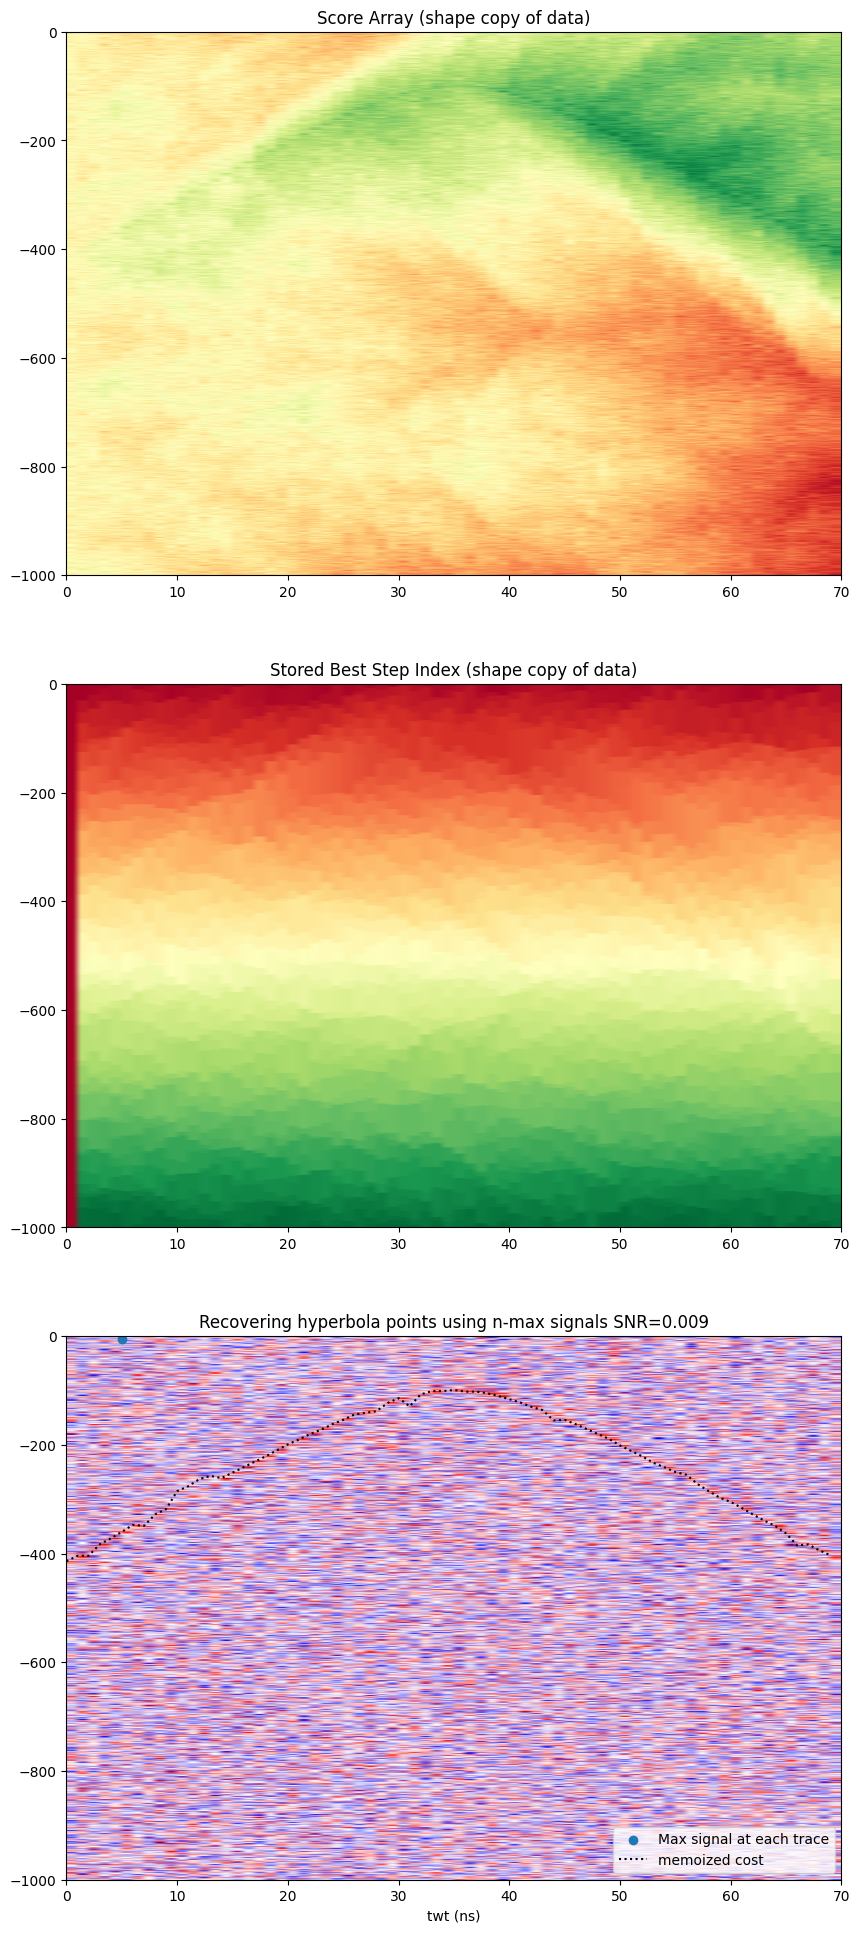

In [475]:
def smooth_path_dp(data, lam):
    """
    Dynamic programming path extraction with slope smoothness constraint.

    This function identifies a globally optimal path through a 2D data array
    (e.g., a noisy image or trace stack) by maximizing signal intensity while
    enforcing slope continuity between adjacent columns. It uses dynamic
    programming to accumulate an optimal cost matrix `C`, balancing the
    contribution of local intensity and smoothness between consecutive points.
    The final path is then reconstructed by backtracking from the maximum
    cumulative cost.

    Parameters
    ----------
    data : np.ndarray of shape (nt, nx)
        2D array representing the signal intensity field. Each column corresponds
        to a spatial or temporal "trace", and each row represents a vertical or
        temporal sample (e.g., depth or time). The algorithm finds a continuous
        high-intensity ridge across columns.
    
    lam : float
        Smoothness weighting factor (0 ≤ lam ≤ 1). Higher values increase the
        penalty on large vertical jumps between adjacent columns, promoting smoother
        paths; lower values emphasize following strong intensity values even if the
        path is jagged.

    Returns
    -------
    x : np.ndarray of shape (nx,)
        Column indices corresponding to each trace position.
    
    path : np.ndarray of shape (nx,)
        Row indices of the optimal path through the data, reconstructed from
        backtracking the maximum cumulative cost.
    
    C : np.ndarray of shape (nt, nx)
        Accumulated cost matrix representing the maximum achievable cumulative
        score up to each point (t, x) in the grid.
    
    backtrack : np.ndarray of shape (nt, nx)
        Index matrix storing the best predecessor for each (t, x), used to recover
        the final optimal path during backtracking.

    Notes
    -----
    - The dynamic programming formulation implicitly accounts for multi-column
      (global) slope trends since each column’s optimal cost includes all previous
      transitions. Thus, even though the local slope penalty is evaluated only
      against the immediate previous column, the optimization captures consistent
      longer-term slope behavior.
    - The computational complexity is O(nt² × nx), which can be reduced by
      restricting the allowed vertical transition range between columns.
    """
    nt, nx = data.shape
    C = np.zeros_like(data)
    backtrack = np.zeros_like(data, dtype=int)

    # Initialize first column
    C[:, 0] = data[:, 0]

    # DP forward pass, populate the memoized cost (C) and store the best path so far. This can be improved from n^2 but I thnk it's alright for now
    for x in range(1, nx):
        for t in range(nt):
            # Compute smoothness penalty relative to previous column, slope cost may not be needed
            penalties = ((1-lam)*C[:, x-1]) - (lam * (np.arange(nt) - t)**2)
            best_prev = np.argmax(penalties)
            C[t, x] = data[t, x] + penalties[best_prev]
            backtrack[t, x] = best_prev
    # Backtrack the best path
    path = np.zeros(nx, dtype=int)
    path[-1] = np.argmax(C[:, -1])
    for x in range(nx-2, -1, -1):
        path[x] = backtrack[path[x+1], x+1]

    return np.arange(0, nx), -path, C, backtrack

x_dynamic, t_dynamic, cost, memo = smooth_path_dp(data, lam=0.001)

fig, ax = plt.subplots(3, figsize=(10,24))
ax[0].imshow(cost-cost.mean(axis=0), aspect='auto', extent=[0,70,-1000,0], cmap='RdYlGn'); ax[0].set_title("Score Array (shape copy of data)")
ax[1].imshow(memo, aspect='auto', extent=[0,70,-1000,0], cmap="RdYlGn"); ax[1].set_title("Stored Best Step Index (shape copy of data)")
ax[2].set_title(f"Recovering hyperbola points using n-max signals SNR={SNR}"); ax[2].set_xlabel("Trace distance (m)"); ax[2].set_xlabel("twt (ns)")
ax[2].imshow(data, aspect='auto', extent=[0,70,-1000,0], cmap='seismic')
ax[2].scatter(x, -t, label="Max signal at each trace")
ax[2].plot(x_dynamic, t_dynamic, label="memoized cost", c='black', linestyle=':')
ax[2].legend(loc="lower right")

# Now that we've recovered a decent path, just do pinv fit

In [194]:
def get_hyp_params(data):
    x, t, c, m = smooth_path_dp(data, lam=0.002) # 'clean' the input data to find good x, t(x) inputs to fit to

    # Our linearized form of the hyperbola equation
    A = np.column_stack([t**2, 2.0*x, -1.0*np.ones_like(x)])
    b = x**2
    
    # solve with pseudoinverse -- do this twice to reduce outliers
    consts = np.linalg.pinv(A) @ b
    r = A@consts - b  
    sigma = 1.5 * np.median(np.abs(r - np.median(r))) # scale mad
    
    mask = np.abs(r) <= 0.5 * sigma
    consts2 = np.linalg.pinv(A[mask]) @ b[mask]
    alpha, beta, gamma = consts2

    v = 2.0 * np.sqrt(alpha) * 1e9
    x0 = beta
    z = np.sqrt(gamma - x0**2)
    t0 = z/v
    print(f"v = {v:.1f} m/s, depth z = {z:.2f} m, apex x0 = {x0:.3f} m, t0 = {t0} s")
    
    return v, z, x0, t0

v, z, x0, t0 = get_hyp_params(data)

v = 173262977.8 m/s, depth z = 8.67 m, apex x0 = 35.002 m, t0 = 5.005482580906848e-08 s


# This looks quite nice, Lets gradually degrade the SNR ot see how the alg responds

In [205]:
# Parameters
eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
wavetype = 'gaussian'
# Point reflectors at (x,t) where x [m] and t [s]
reflectors = [(35, 50e-9)]
x_0, t_0 = reflectors[0][0], reflectors[0][1]

drs = []
dx0s = []
dt0s = []
for SNR in [10, 1, 0.1, 0.05, 0.01, 0.009]:
    dr = np.zeros(5)
    dx0 = np.zeros(5)
    dt0 = np.zeros(5)
    for j in range(0,5):
        data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
        v, z, x0, t0 = get_hyp_params(data)
        dr[j] = ((np.abs(eps_r-(3e8/v)**2)) / ((np.abs(eps_r+(3e8/v)**2))/2))*100
        dx0[j] = ((np.abs(x_0-x0)) / ((np.abs(x_0+x0)/2)))*100
        dt0[j] = ((np.abs(t_0-t0)) / ((np.abs(t_0+t0)/2)))*100
    drs.append(np.mean(dr))
    dx0s.append(np.mean(dx0))
    dt0s.append(np.mean(dt0))
        
        

v = 173256789.5 m/s, depth z = 8.67 m, apex x0 = 35.003 m, t0 = 5.0067264874104086e-08 s
v = 173218426.7 m/s, depth z = 8.67 m, apex x0 = 35.000 m, t0 = 5.004209703458978e-08 s
v = 173187310.9 m/s, depth z = 8.67 m, apex x0 = 34.994 m, t0 = 5.0038392749048944e-08 s
v = 173212312.0 m/s, depth z = 8.66 m, apex x0 = 35.000 m, t0 = 5.00249457913584e-08 s
v = 173218073.2 m/s, depth z = 8.67 m, apex x0 = 34.999 m, t0 = 5.0054686906820675e-08 s
v = 173144803.8 m/s, depth z = 8.68 m, apex x0 = 34.992 m, t0 = 5.010579302576876e-08 s
v = 173263706.4 m/s, depth z = 8.68 m, apex x0 = 35.003 m, t0 = 5.008206638077462e-08 s
v = 173284349.5 m/s, depth z = 8.67 m, apex x0 = 35.000 m, t0 = 5.0056744502662326e-08 s
v = 173277726.3 m/s, depth z = 8.67 m, apex x0 = 35.000 m, t0 = 5.004529548402052e-08 s
v = 173306623.0 m/s, depth z = 8.69 m, apex x0 = 35.001 m, t0 = 5.013122185691412e-08 s
v = 173099853.5 m/s, depth z = 8.64 m, apex x0 = 35.004 m, t0 = 4.9923017729356736e-08 s
v = 173338180.8 m/s, depth z

Text(0, 0.5, '% difference')

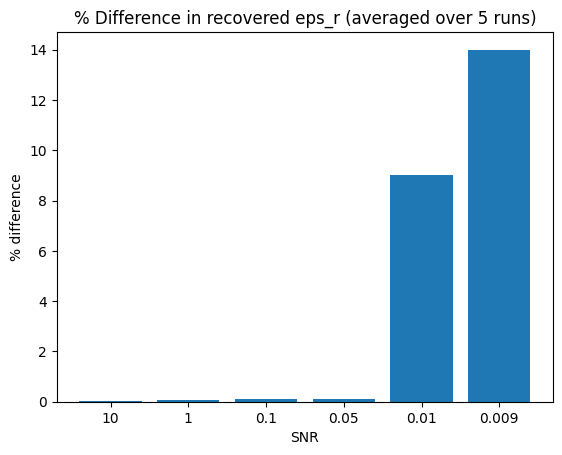

In [208]:
x = ["10", "1", "0.1", "0.05", "0.01", "0.009"]
plt.bar(x, drs); plt.title("% Difference in recovered eps_r (averaged over 5 runs)"); plt.xlabel("SNR"); plt.ylabel("% difference")

v = 173221252.0 m/s, depth z = 8.67 m, apex x0 = 35.000 m, t0 = 5.005106153627434e-08 s
v = 173221252.0 m/s, depth z = 8.67 m, apex x0 = 35.000 m, t0 = 5.005106153627434e-08 s
v = 197929786.9 m/s, depth z = 9.62 m, apex x0 = 31.247 m, t0 = 4.8590117566935524e-08 s
v = 197929786.9 m/s, depth z = 9.62 m, apex x0 = 31.247 m, t0 = 4.8590117566935524e-08 s


(-1000.0, 0.0)

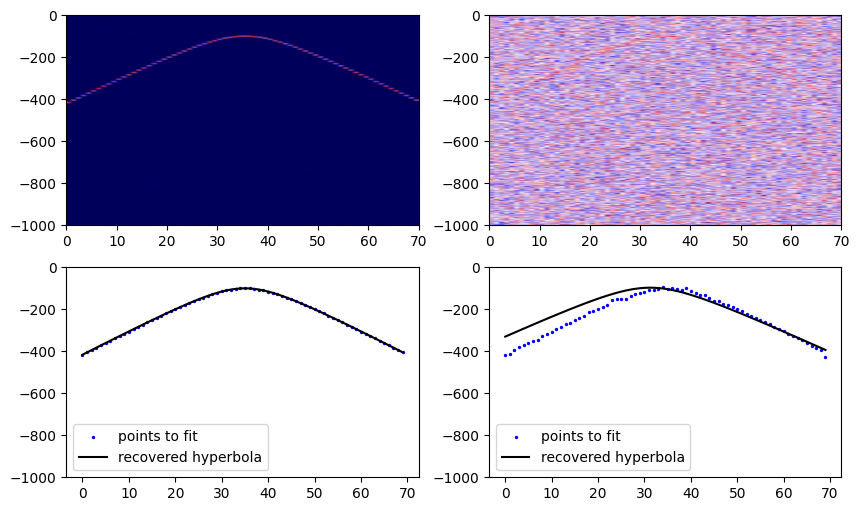

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(10,6))
plt.gca()

eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
wavetype = 'gaussian'
reflectors = [(35, 50e-9)]
SNR = 100
x_0, t_0 = reflectors[0][0], reflectors[0][1]

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
axs[0][0].imshow(data, aspect='auto', extent=[0,70,-1000,0], cmap='seismic')
v, z, x0, t0 = get_hyp_params(data)
x_dynamic, t_dynamic = smooth_path_dp(data, lam=0.001)
axs[1][0].scatter(x_dynamic, t_dynamic, label="points to fit", s=2, c='blue')
v, z, x0, t0 = get_hyp_params(data)
x = np.arange(0, region_shape[0], dx)
axs[1][0].plot(x, -(2/v)*np.sqrt(z**2 + (x-x0)**2)*1e9, label='recovered hyperbola', c='black')
axs[1][0].legend()
axs[1][0].set_ylim(-1000,0)


eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
wavetype = 'gaussian'
reflectors = [(35, 50e-9)]
SNR = 0.009
x_0, t_0 = reflectors[0][0], reflectors[0][1]

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
axs[0][1].imshow(data, aspect='auto', extent=[0,70,-1000,0], cmap='seismic')
v, z, x0, t0 = get_hyp_params(data)
x_dynamic, t_dynamic = smooth_path_dp(data, lam=0.001)
axs[1][1].scatter(x_dynamic, t_dynamic, label="points to fit", s=2, c='blue')
v, z, x0, t0 = get_hyp_params(data)
x = np.arange(0, region_shape[0], dx)
axs[1][1].plot(x, -(2/v)*np.sqrt(z**2 + (x-x0)**2)*1e9, label='recovered hyperbola', c='black')
axs[1][1].legend()
axs[1][1].set_ylim(-1000,0)

In [68]:
47/(1e-4*600000)

0.7833333333333333